# Q1.1.1

In [305]:
# Import the necessary libraries
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FormatStrFormatter

import scipy.stats as stats
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.special import expit, logit

In [2]:
im_slice = 71
vox_i = 91
vox_j = 64
dim_i = 145
dim_j = 174

In [3]:
# Load in the diffusion MRI data set
dwis = loadmat('data.mat')['dwis']
dwis = np.double(dwis)
dwis = dwis.transpose((3, 0, 1, 2))
[Dc, Dx, Dy, Dz] = dwis.shape
print(dwis.shape)

(108, 145, 174, 145)


In [4]:
# And the settings for each component image
qhat = np.loadtxt("bvecs", delimiter = " ").T
bvals = 1000 * np.sum(qhat * qhat, axis=1)
print(qhat.shape, bvals.shape)

(108, 3) (108,)


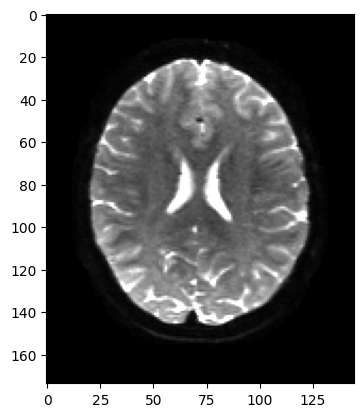

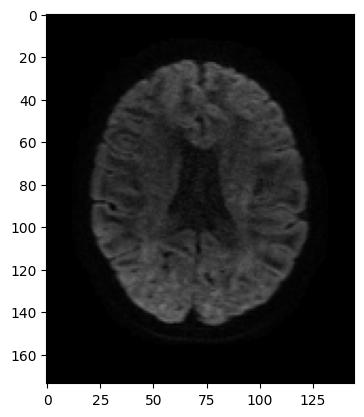

In [5]:
# Look at a single slice in a few channels
for i in range(0,2):
    plt.figure()
    plt.imshow(np.flipud(dwis[i,:,:,im_slice].T),cmap='gray',vmax=10000)
    plt.show()

In [6]:
# Solve for x in log(A) = Gx - where x has all unknowns
x = np.zeros((dim_i, dim_j, 7))
quadratic_matrix = -bvals * np.array([qhat[:,0]**2, 2*qhat[:,0]*qhat[:,1], 2*qhat[:,0]*qhat[:,2], qhat[:,1]**2, 2*qhat[:,1]*qhat[:,2], qhat[:,2]**2])
G = np.concatenate([np.ones((108,1)), quadratic_matrix.T], axis=1)

for i in range(dim_i):
    for j in range(dim_j):
        A = dwis[:,i,j,im_slice]
        if np.min(A) > 0:
            W = np.diag(A**2)
            invmap = np.linalg.pinv(G.T @ W @ G) @ G.T @ W
            x[i,j,:] = invmap @ np.log(A)

D = np.zeros((dim_i,dim_j,3,3))
for i in range(dim_i):
    for j in range(dim_j):
        Dxx = x[i,j,1]
        Dxy = x[i,j,2]
        Dxz = x[i,j,3]
        Dyy = x[i,j,4]
        Dyz = x[i,j,5]
        Dzz = x[i,j,6]
        D[i,j] = np.array(
            [[Dxx, Dxy, Dxz],
             [Dxy, Dyy, Dyz],
             [Dxz, Dyz, Dzz]]
        )



In [7]:
# Calculate mean diffusivity
mean_D = np.zeros((dim_i,dim_j))

for i in range(dim_i):
    for j in range(dim_j):
        mean_D[i,j] = np.trace(D[i,j]) / 3

# Calculate FA
FA = np.zeros((dim_i,dim_j))
eig_val_D = np.zeros(((dim_i,dim_j,3)))
eig_vec_D = np.zeros((dim_i,dim_j,3,3))

for i in range(dim_i):
    for j in range(dim_j):
        eig_val, eig_vec = np.linalg.eig(np.squeeze(D[i,j]))
        eig_vec_D[i,j,:,:] = eig_vec
        eig_val_D[i,j,:] = eig_val
        if eig_val.sum() > 0:
            FA[i,j] = np.sqrt(1.5 * np.sum((eig_val - eig_val.mean())**2) / (eig_val**2).sum())

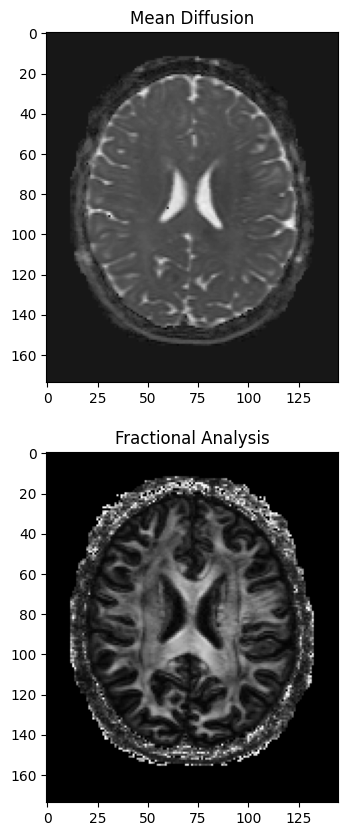

In [8]:
# plot FA
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].imshow(np.flipud(mean_D.T), cmap='gray')
axs[0].set_title('Mean Diffusion')

axs[1].imshow(np.flipud(FA.T), cmap='gray')
axs[1].set_title('Fractional Analysis')

# Show the plot
plt.show()


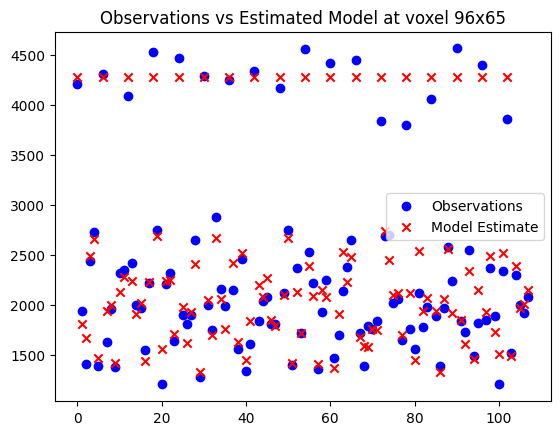

In [9]:
# Plot the model estimate against the measure signal at voxel 96,65 across all slices

A_est = np.exp(G @ np.squeeze(x[vox_i,vox_j,:]).reshape((-1,1)))
A_exact = np.squeeze(dwis[:,vox_i,vox_j,im_slice])
# Create grid of subplots
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), A_est, marker='x', color='r', label='Model Estimate')
plt.legend()
plt.title('Observations vs Estimated Model at voxel 96x65')
plt.show()

<function numpy.transpose(a, axes=None)>

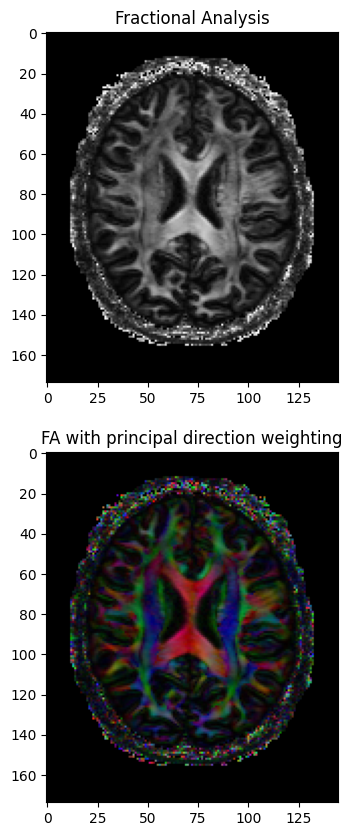

In [10]:
# Plot the FA weighted with eigenvalues on RBG spectrum
FA_RGB = np.zeros((dim_i,dim_j,3))

for i in range(dim_i):
    for j in range(dim_j):
        principal_eig_idx = np.argmax(np.abs(eig_val_D[i,j]))
        if eig_val_D[i,j,principal_eig_idx] > 0:
            eig_vec = eig_vec_D[i,j,:,principal_eig_idx]
            FA_RGB[i,j,:] = FA[i,j] * np.abs(np.array([eig_vec[0], eig_vec[1], eig_vec[2]]))

# normalise RGB values
FA_RGB = FA_RGB / np.max(FA_RGB)

# print to screen FA_RGB
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].imshow(np.flipud(FA.T), cmap='gray')
axs[0].set_title('Fractional Analysis')

axs[1].imshow(np.flipud(np.transpose(FA_RGB, (1,0,2))))
axs[1].set_title('FA with principal direction weighting')

np.transpose


# Q1.1.2
### Ball and Stick Model

In [11]:
def ball_stick(x):
    # Behrens et al, 2003
    # Characterization and Propagation of Uncertainty in Diffusion-Weighted MR Imaging
    # https://doi.org/10.1002/mrm.10609
    
    # Extract the parameters
    # diff: diffusion
    # f: fraction of signal contributed by diffusion tensor along fiber direction theta, phi
    S0, diff, f, theta, phi = x
    
    # Fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta),
    ])
    
    # creates a 2D array of fibdir stacked ontop of each other len(bvals) times
    # so now has the dimensions [len(bvals)x3]
    tile = np.tile(fibdir, (len(bvals), 1))
    fibdotgrad = np.sum(qhat * tile, axis=1)
    
    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
    return S


def BallStickSSD(x, voxel):
    S = ball_stick(x)
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)

In [12]:
# Use minimize for non-linear estimation of the ball-and-stick parameters
# The first starting point finds a spurious local min; the second
# a more reasonable min.
avox = dwis[:,vox_i,vox_j,im_slice]
#startx = np.array([3500, -5e-6, 120, 0, 0])
#startx = np.array([4200, 4e-4, 0.25, 0, 0])
# start given by moodle note:
startx = np.array([3300, 1.0e-03, 4.5e-01, 1.0, 1.0])
results = minimize(
    fun=BallStickSSD,
    x0=startx,
    args=(avox,),
)

results

C:\Users\fl_cl\AppData\Local\Temp\ipykernel_11440\2916082994.py:23: RuntimeWarning: overflow encountered in exp
  S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
c:\Users\fl_cl\miniconda3\envs\MV00-py3.9\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_11440\2916082994.py:23: RuntimeWarning: overflow encountered in exp
  S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_11440\2916082994.py:30: RuntimeWarning: overflow encountered in square
  return np.sum((voxel - S) ** 2)


      fun: 54806552.90143531
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([-4.47215000e+04,  4.98960658e+10,  1.76876395e+07, -1.44313685e+07,
        1.24521480e+07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 30
      nit: 0
     njev: 3
   status: 2
  success: False
        x: array([3.3e+03, 1.0e-03, 4.5e-01, 1.0e+00, 1.0e+00])

error mean: -318.7261807778814
error std: 640.0585840856426
estimated SS: 44244899.0346655, calculated SS: 54806552.90143531, diff: -10561653.866769806


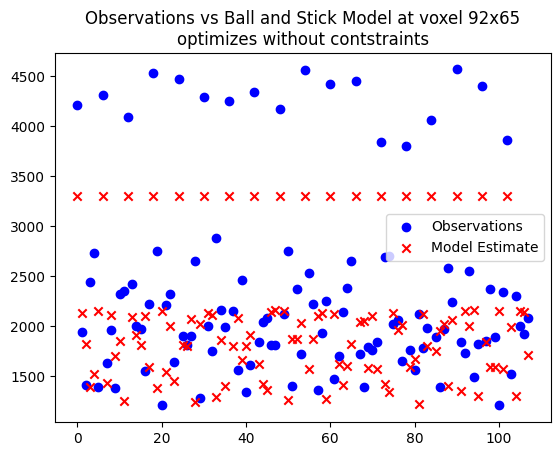

In [13]:
# Use the fitted parameters to get estimated values
A_est = ball_stick(results['x'])
A_exact = np.squeeze(dwis[:,vox_i,vox_j,im_slice])

# Find the mean and std of the errors
error_dist = stats.describe(A_est - A_exact)
error_mean = error_dist[2]
error_var = error_dist[3]
print(f"error mean: {error_mean}")
print(f"error std: {np.sqrt(error_var)}")

# Use the standard deviation to calculate the estimated Sum of Squares diff
ss_est = 108 * error_var
ss_exact = results['fun']
print(f"estimated SS: {ss_est}, calculated SS: {ss_exact}, diff: {ss_est - ss_exact}")

# Create grid of subplots to compare
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), A_est, marker='x', color='r', label='Model Estimate')
plt.legend()
plt.title(f'Observations vs Ball and Stick Model at voxel {vox_i+1}x{vox_j+1}\noptimizes without contstraints')
plt.show()

In [14]:
# Find the mean and std of the errors
error_dist = stats.describe(A_est - A_exact)
error_mean = error_dist[2]
error_var = error_dist[3]
print(f"error mean: {error_mean}")
print(f"error std: {np.sqrt(error_var)}")

# Use the standard deviation to calculate the estimated Sum of Squares diff
ss_est = 108 * error_var
ss_exact = results['fun']
print(f"estimated SS: {ss_est}, calculated SS: {ss_exact}, diff: {ss_est - ss_exact}")

error mean: -318.7261807778814
error std: 640.0585840856426
estimated SS: 44244899.0346655, calculated SS: 54806552.90143531, diff: -10561653.866769806


# Q1.1.3

In [15]:
# We are now constraining the parameters (S0, diff >0, f in (0,1), theta, phi in (0,2pi))
# We do this by transforming x to be squared, or expit() and scaled to ensure they are in the 
# correct domain. Because the transformation happens after the optimizer guesses x_t+1 we
# have to transform the optimized solution to get the correct fitted parameters

# Given S0, diff, f, theta and phi - we transform to constrain it
def transform(x):
    """
    so = x[0]
    diff = x[1]
    f = x[2]
    theta = x[3]
    phi = x[4]
    """
    return [x[0]**2, x[1]**2, expit(x[2]), expit(x[3])*np.pi, expit(x[4])*2*np.pi]

# Given transformed x return parameters we are looking for
def transform_inv(x):
    """
    so**2 = x[0]
    diff**2 = x[1]
    expit(f) = x[2]
    pi*expit(theta) = x[3]
    2*pi*expit(phi) = x[4]
    """
    return [x[0]**0.5, x[1]**0.5, logit(x[2]), logit(x[3]/(np.pi)), logit(x[4]/(2*np.pi))]

def BallStickSSD_constrained(x, voxel):
    S = ball_stick(transform(x))
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)


In [16]:
# Use the transform to find the parameters constrained
results = minimize(
    fun=BallStickSSD_constrained,
    x0=transform_inv(startx),
    args=(avox,),
)

results

# With constraints the fitting works and we get sensible results (S0, diff >0, etc.)
# and plotting against observed values we get much better results

      fun: 5871996.800798102
 hess_inv: array([[ 2.20165758e-05, -4.17141458e-08,  5.44591774e-06,
         4.70446133e-06,  5.50197618e-06],
       [-4.17141458e-08,  8.06144786e-11, -1.04697159e-08,
        -8.87274028e-09, -1.03730058e-08],
       [ 5.44591774e-06, -1.04697159e-08,  1.38064626e-06,
         1.15553132e-06,  1.34915466e-06],
       [ 4.70446133e-06, -8.87274028e-09,  1.15553132e-06,
         1.01518555e-06,  1.19411094e-06],
       [ 5.50197618e-06, -1.03730058e-08,  1.34915466e-06,
         1.19411094e-06,  1.47570995e-06]])
      jac: array([ 0.1875,  5.3125, -0.125 , -0.3125,  0.0625])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 448
      nit: 32
     njev: 73
   status: 2
  success: False
        x: array([ 6.52527790e+01, -3.37830607e-02, -5.87056279e-01,  7.89459938e-01,
       -2.28680659e+00])

error mean: 0.11698199288636496
error std: 234.26152257921527
estimated SS: 5926873.783802276, calculated SS: 5871996.800798102, diff: 54876.983004173264


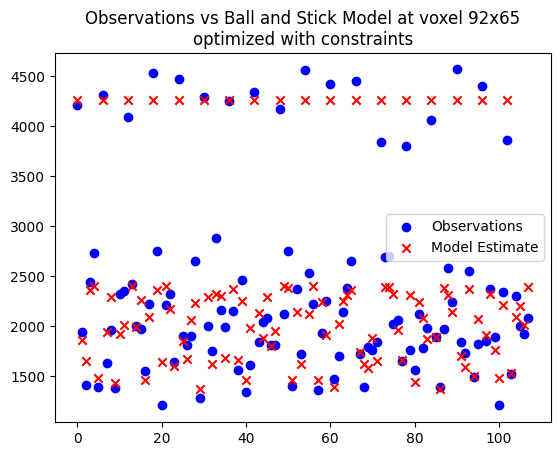

In [17]:
# Use the fitted parameters to get estimated values
#A_est = ball_stick(transform(results['x']))
#A_exact = np.squeeze(dwis[:,91,64,71])
A_est = ball_stick(transform(results['x']))
A_exact = np.squeeze(dwis[:,vox_i,vox_j,im_slice])

# Find the mean and std of the errors
error_dist = stats.describe(A_est - A_exact)
error_mean = error_dist[2]
error_var = error_dist[3]
print(f"error mean: {error_mean}")
print(f"error std: {np.sqrt(error_var)}")

# Use the standard deviation to calculate the estimated Sum of Squares diff
ss_est = 108 * error_var
ss_exact = results['fun']
print(f"estimated SS: {ss_est}, calculated SS: {ss_exact}, diff: {ss_est - ss_exact}")

# Create grid of subplots to compare
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), A_est, marker='x', color='r', label='Model Estimate')
plt.legend()
plt.title(f'Observations vs Ball and Stick Model at voxel {vox_i+1}x{vox_j+1}\noptimized with constraints')
plt.show()

Sum of sqares has significantly reduced because now the model is fitting the observed data much better

# Q1.1.4

In [18]:
# for the same voxel run multiple times to try and find the best minimum
def BallStickSSD_constrained_findSSDmin(max_iter, startx, avox):
    # given parameters of a single avox, run max_iter times and find converged SSD each time
    # return all found solutions and SSD values
    
    noise_std = startx / 5
    num_parameters = startx.size
    X_single_voxel = np.zeros((max_iter, num_parameters))
    X_SSD = np.zeros(max_iter)

    for i in range(max_iter):
        # find some noise, add to the start, and transform and inverse it to make sure the 
        # peturbed start is a realistic start
        noise = np.random.normal(loc=np.zeros(num_parameters), scale=noise_std)
        x_i = startx + noise
        x_i = transform_inv(transform(x_i))
        results = minimize(
            fun=BallStickSSD_constrained,
            x0=transform_inv(x_i),
            args=(avox,),
        )
        X_single_voxel[i,:] = results['x']
        SSD_result = results['fun']
        if np.isnan(SSD_result):
            SSD_result = np.inf
        X_SSD[i] = SSD_result
    
    return X_single_voxel, X_SSD


def find_prob_finding_SSD_globalmin(startx, avox, max_iter=100, eps=1e-1):
    # given a voxex, and a starting position. Optimize to solve for x with 95% confidence the global minima has been found
    
    X_single_voxel, X_SSD = BallStickSSD_constrained_findSSDmin(max_iter, startx=startx, avox=avox)
    
    min_SSD = np.min(X_SSD)
    min_SSD_count = np.isclose(X_SSD, min_SSD, eps).sum()
    p = min_SSD_count / X_SSD.shape[0]
    print(f"min_SSD: {min_SSD}, prob_global_min = {p}")
    return p


def find_N_for_95percent_global_min(p):
    return int(np.ceil(np.log(0.05) / np.log(1-p)))

"""
so = x[0]
diff = x[1]
f = x[2]
theta = x[3]
phi = x[4]
"""

'\nso = x[0]\ndiff = x[1]\nf = x[2]\ntheta = x[3]\nphi = x[4]\n'

In [19]:
# Look at the results of X_SSD. See what the reoccurance of the min was (within some tolerance) and use that as a
# probability of hitting the min to get an estimate on howmany times we need to run it to be 95% sure
voxel_idxs = np.array([[vox_i,vox_j], [60,60], [55,55], [80,60], [85,55], [85, 72], [70, 70]])
N_array = np.zeros(shape=voxel_idxs.shape[0])

for i, voxel_idx in enumerate(voxel_idxs):
    p = find_prob_finding_SSD_globalmin(startx, dwis[:, voxel_idx[0], voxel_idx[1], im_slice], max_iter=100)
    N_array[i] = find_N_for_95percent_global_min(p)

print(f"Found Ns: {N_array}")
N_global_min = int(N_array.max())
print(f"Will use the max N found in our small sample: max_N = {N_global_min}")

min_SSD: 5871996.800732266, prob_global_min = 0.83
min_SSD: 3973422.185099289, prob_global_min = 0.99
min_SSD: 6565608.199867191, prob_global_min = 0.99
min_SSD: 3494706.812709123, prob_global_min = 0.84
min_SSD: 3234355.125884892, prob_global_min = 0.32
min_SSD: 8882585.584203497, prob_global_min = 0.27
min_SSD: 4253463.440251824, prob_global_min = 1.0
Found Ns: [ 2.  1.  1.  2.  8. 10.  0.]
Will use the max N found in our small sample: max_N = 10


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_11440\886908193.py:44: RuntimeWarning: divide by zero encountered in log
  return int(np.ceil(np.log(0.05) / np.log(1-p)))


# Q1.1.5

In [20]:
# use the max N found across all voxels to find the global min

is_skip = True
file_path = "X_optimize_each_voxel_with_same_N.npy"

if not is_skip:
    X = np.zeros((dim_i, dim_j, startx.size))
    X = np.load(file_path)

    for i in range(dim_i):
        for j in range(dim_j):
            A = dwis[:,i,j,im_slice]
            if np.min(A) > 0:
                x_single_voxel, x_SSD = BallStickSSD_constrained_findSSDmin(N_global_min, startx, dwis[:,i,j,im_slice])
                min_idx = np.argmin(x_SSD)
                X[i,j,:] = transform(x_single_voxel[min_idx,:])
        # save each row to a file
        np.save(file_path, X)
        print(f"row {i} complete")
else:
    X = np.load(file_path)



error mean: -0.01978829664985445
error std: 179.00867990500365
estimated SS: 3460763.6079838625, calculated SS: 5871996.800798102, diff: -2411233.1928142398


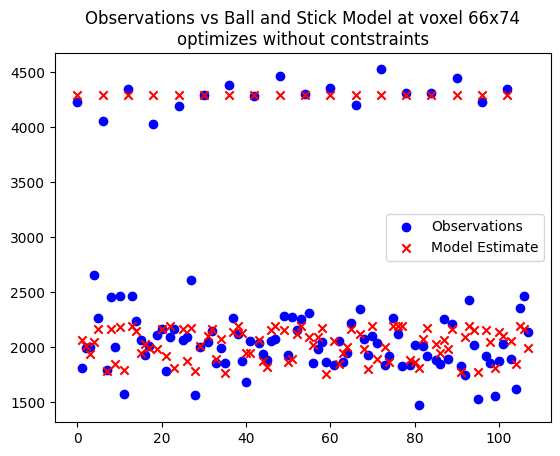

In [21]:
# Use the fitted parameters to get estimated values
idx = 65
jdx = 73
A_est = ball_stick(X[jdx,idx])
A_exact = np.squeeze(dwis[:,jdx,idx,im_slice])

# Find the mean and std of the errors
error_dist = stats.describe(A_est - A_exact)
error_mean = error_dist[2]
error_var = error_dist[3]
print(f"error mean: {error_mean}")
print(f"error std: {np.sqrt(error_var)}")

# Use the standard deviation to calculate the estimated Sum of Squares diff
ss_est = 108 * error_var
ss_exact = results['fun']
print(f"estimated SS: {ss_est}, calculated SS: {ss_exact}, diff: {ss_est - ss_exact}")

# Create grid of subplots to compare
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), A_est, marker='x', color='r', label='Model Estimate')
plt.legend()
plt.title(f'Observations vs Ball and Stick Model at voxel {idx+1}x{jdx+1}\noptimizes without contstraints')
plt.show()

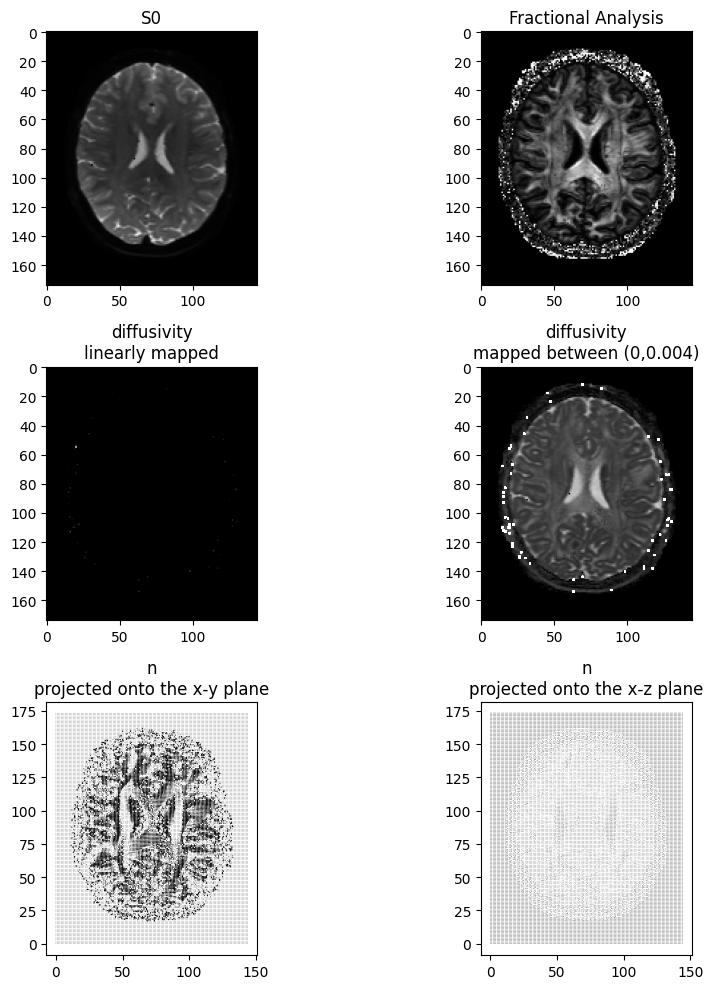

In [140]:
# plot the S0, d, f, and the RESNORM, and fibre direction of n
"""
so = x[0]
diff = x[1]
f = x[2]
theta = x[3]
phi = x[4]
"""

S0 = X[:,:,0]
d_raw = X[:,:,1]
d_processed = np.where(d_raw > 3, 0, d_raw)
f = X[:,:,2]
theta = X[:,:,3]
phi = X[:,:,4]

n_zplane_x = np.sin(theta) * np.cos(phi) * f
n_zplane_y = - np.sin(theta) * np.sin(phi)

n_yplane_x = np.sin(theta) * np.sin(phi) * f
n_yplane_y = np.cos(theta)


# plot FA
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(3,2, figsize=(10, 10))

axs[0,0].imshow(np.flipud(S0.T), cmap='gray')
axs[0,0].set_title('S0')

axs[0,1].imshow(np.flipud(f.T), cmap='gray')
axs[0,1].set_title('Fractional Analysis')

axs[1,0].imshow(np.flipud(d_raw.T), cmap='gray')
axs[1,0].set_title('diffusivity\nlinearly mapped')

axs[1,1].imshow(np.flipud(d_raw.T), cmap='gray', vmax=0.004)
axs[1,1].set_title('diffusivity\nmapped between (0,0.004)')

axs[2,0].quiver(n_zplane_x.T, n_zplane_y.T)
axs[2,0].set_title('n\nprojected onto the x-y plane')
axs[2,0].set_aspect('equal')

axs[2,1].quiver(n_yplane_x.T, n_yplane_y.T)
axs[2,1].set_title('n\nprojected onto the x-z plane')
axs[2,1].set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.show()

There are many outliers in the found parameters so there are some found parameters that don't have found solutions. This can be seen in the diffusivity model where the found solutions are much larger than they should be which skews the mapping making the image black with a few highlighted outliers. If we only plot diffusivity for the majority (d < 0.005) then we get more of a picture we would expect (outliers are very bright in that image)

# Q1.2.1

In [130]:
# Classical Bootstrapping method
# Sample with replacement T times to get A_t sampled data set. Each data set solve for parameters
# Plot the found parameters on a histogram and keep the middle 95%. Calculate sigma for the estimate
def calssical_bootstrap_find_parameters(vox_i, vox_j, im_slice, T=300):
    N_data = dwis.shape[0]
    # create indexes for T different iteration, each iteration have N samples indexes
    sampled_idxs = np.random.randint(N_data, size=(T,N_data))
    bootstrap_parameters = np.zeros(shape=(T, 5))

    for t in range(T):
        A_t = dwis[sampled_idxs[t], vox_i, vox_j, im_slice]
        if np.min(A_t > 0):
            x_single_voxel, x_SSD = BallStickSSD_constrained_findSSDmin(N_global_min, startx, A_t)
            min_idx = np.argmin(x_SSD)
            bootstrap_parameters[t,:] = transform(x_single_voxel[min_idx,:])
    
    return bootstrap_parameters


In [282]:
# method to plot the histogram of bootstrap parameters given data and axes
def plot_histogram_sigma_95percent(axs, data, title, shade_colour='grey', shade_alpha=0.4, sigma_line_colour='red', mean_colour='black', is_legend=False):
    T = data.size
    data_std = np.std(data)
    data_sorted_idx = np.argsort(data)
    data_95_idx = [data_sorted_idx[int(T * 0.025)], data_sorted_idx[int(T * 0.975)]]
    data_95_range = [data[data_95_idx[0]], data[data_95_idx[1]]]
    data_2sigma_range = [data.mean() - 2*data_std, data.mean() + 2*data_std]

    # plot histograms of data with shaded 95% region, and line showing 2 sigma range
    height_values, _, _ = axs.hist(data)
    axs.axvspan(xmin=data_95_range[0], xmax=data_95_range[1], facecolor=shade_colour, alpha=shade_alpha, label='95% confidence')
    axs.plot(data_2sigma_range, [height_values.max()/2,height_values.max()/2], marker='|', c=sigma_line_colour, label='2 sigma range')
    axs.scatter(data.mean(), height_values.max()/2, marker='x', c=mean_colour, label='parameter mean')
    if is_legend:
        axs.legend()
    axs.set_title(title)
    
    return data_95_range, data_2sigma_range

Bootstrap parameter ranges

Voxel: 92x65
S0: mean = 2514.871977283852, 95% confidence = [2264.23038219 2917.58271151], 2sigma range = [2206.4213117  2823.32264286]
Diffusivity: mean = 0.00021209739436089625, 95% confidence = [3.27034849e-05 4.07427239e-04], 2sigma range = [2.46128719e-05 3.99581917e-04]
f: mean = 0.9243846561228645, 95% confidence = [0.41400335 1.        ], 2sigma range = [0.57435123 1.27441809]

Voxel: 65x81
S0: mean = 2042.5847602827528, 95% confidence = [1785.30141268 2325.4286872 ], 2sigma range = [1780.03150251 2305.13801805]
Diffusivity: mean = 0.00024777829743080664, 95% confidence = [8.46310472e-18 4.72323540e-04], 2sigma range = [1.77896776e-05 4.77766917e-04]
f: mean = 0.9248307359150739, 95% confidence = [0.44055446 1.        ], 2sigma range = [0.5978299  1.25183157]

Voxel: 71x76
S0: mean = 1877.9798315676135, 95% confidence = [1679.55381695 2115.37653794], 2sigma range = [1653.37052218 2102.58914096]
Diffusivity: mean = 0.00024051827488013323, 95% confiden

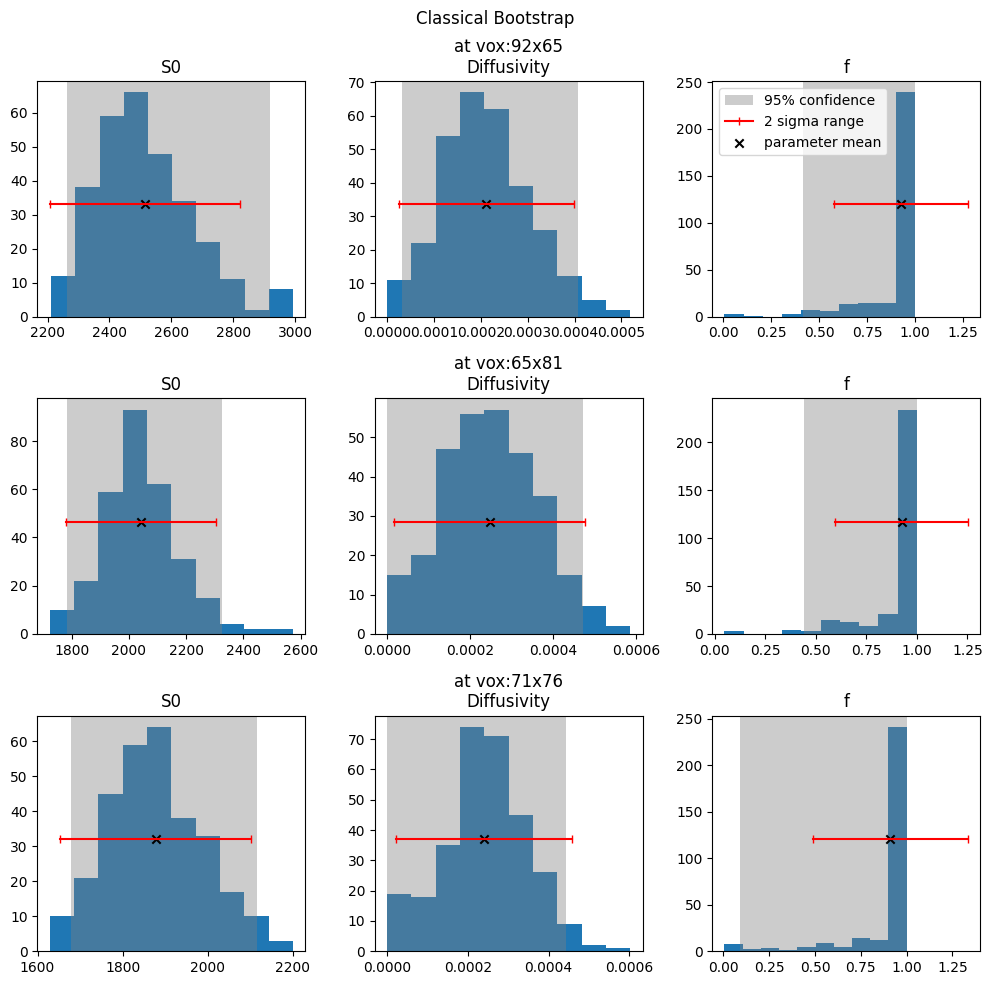

In [320]:
# use classical bootstrapping method to find a range of parameters and plot on a histogram
fig, axs = plt.subplots(3,3, figsize=(10, 10))
fig.suptitle(f'Classical Bootstrap')

vox_is = np.array([vox_i, 64, 70])
vox_js = np.array([vox_j, 80, 75])

bootstrap_2sigma_range = np.zeros(shape=(3,2))
bootstrap_95_range = np.zeros(shape=(3,2))


print('Bootstrap parameter ranges\n')
for vox in range(vox_is.size):
    if vox==0:
        is_legend=True
    else:
        is_legend=False
    bootstrap_parameters = calssical_bootstrap_find_parameters(vox_is[vox], vox_js[vox], im_slice=im_slice, T=300)
    bootstrap_95_range[0,:], bootstrap_2sigma_range[0,:] = plot_histogram_sigma_95percent(axs[vox, 0], bootstrap_parameters[:,0], 'S0')
    bootstrap_95_range[1,:], bootstrap_2sigma_range[1,:] = plot_histogram_sigma_95percent(axs[vox, 1], bootstrap_parameters[:,1], f'at vox:{vox_is[vox]+1}x{vox_js[vox]+1}\nDiffusivity')
    bootstrap_95_range[2,:], bootstrap_2sigma_range[2,:] = plot_histogram_sigma_95percent(axs[vox, 2], bootstrap_parameters[:,2], 'f', is_legend=is_legend)

    # print the ranges for each parameter:
    print(f'Voxel: {vox_is[vox]+1}x{vox_js[vox]+1}')
    print(f"S0: mean = {bootstrap_parameters.mean(axis=0)[0]}, 95% confidence = {bootstrap_95_range[0]}, 2sigma range = {bootstrap_2sigma_range[0]}")
    print(f"Diffusivity: mean = {bootstrap_parameters.mean(axis=0)[1]}, 95% confidence = {bootstrap_95_range[1]}, 2sigma range = {bootstrap_2sigma_range[1]}")
    print(f"f: mean = {bootstrap_parameters.mean(axis=0)[2]}, 95% confidence = {bootstrap_95_range[2]}, 2sigma range = {bootstrap_2sigma_range[2]}\n")

plt.tight_layout()

The first two plots for S0 and d match fairly well between 2 sigma range and the diffusivity which gives evidence that the distribution could be approximated as a normal. But the f clearly cannot. This is mainly driven by f being close to it's upperlimit of 1

# Q1.2.2
MCMC

for t in range(T):
    y is sampled from dist Q
    calculate alpha(x_t-1, y)
    if alpha > U(0,1):
        x_t = y
    else
        x_t = x_t-1
    remove burn in
    take every stride-th element as sample
    return sample_dist

In [300]:
# given a ndarray of points, and a ndarray of standard deviations for each dimension
# return a point sampled from a gaussian located at the point with std
def q_sample_from_dist(x, param_std):
    # add noise, then transform and inverse then inverse to ensure we remain within our domain
    return transform(transform_inv(x + np.random.randn(x.size) * param_std))

# given parameters x and y, calculate the probability of p(A|y) / p(A|x)
# ie. how likely are we to sample y relative to x
# note: this is assuming the q distribution is symmetrical
def alpha_prob_ratio(y, x, data, noise_std):
    x_SSD = BallStickSSD(x, data)
    y_SSD = BallStickSSD(y, data)
    return np.exp((1 / (2 * noise_std**2)) * (x_SSD - y_SSD))

# given burn_in, number of samples to throw away after burn (stride), and other parameters
# return the samples sequence from the distribution p(x|A)
def MCMC(data, x0=startx, burn_in=100, stride=10, sample_length=100, param_std=startx/5, noise_std=200):
    param_num = 5
    raw_sequence_length = burn_in + stride * sample_length
    raw_sequence = np.zeros(shape=(raw_sequence_length, param_num))
    accepted = np.zeros(raw_sequence_length)
    
    # initialise parameters
    raw_sequence[0,:] = x0
    
    for t in range(1, raw_sequence_length):
        x = raw_sequence[t-1,:]
        y = q_sample_from_dist(x, param_std)
        alpha = alpha_prob_ratio(y, x, data, noise_std=noise_std)
        if alpha > np.random.rand():
            raw_sequence[t] = y
            accepted[t] = 1
        else:
            raw_sequence[t] = x
    
    acceptance_after_burn = accepted[burn_in:].sum()/(raw_sequence_length-burn_in)
    print(f"MCMC Complete: Total sequence length {raw_sequence_length}\nraw acceptance rate of {100*accepted.sum()/raw_sequence_length:.0f}%")
    print(f"after burn in acceptance rate of {100*acceptance_after_burn:.0f}%")
    
    after_burn_sequence = raw_sequence[burn_in:]
    final_sequence_idxs = np.arange(sample_length) * stride
    return after_burn_sequence[final_sequence_idxs], acceptance_after_burn
        

In [301]:
burn_in = 2000
stride = 5
sample_length = 2000

# 82% total
#param_std=np.array([1e1, 1e-6, 1e-3, 1e-2, 1e-2])
# 50% individual
#param_std=np.array([5e1, 4e-5, 2e-2, 6e-2, 8e-2])
# 70% individual
param_std=np.array([3e1, 1.5e-5, 1e-2, 2e-2, 3e-2])

data = dwis[:, vox_i, vox_j, im_slice]
MCMC_sequence, acceptance_rate = MCMC(data, startx, burn_in=burn_in, stride=stride, sample_length=sample_length, param_std=param_std, noise_std=200)

MCMC Complete: Total sequence length 12000
raw acceptance rate of 45%
after burn in acceptance rate of 45%


MCMC parameter ranges

Voxel: 92x65
S0: mean = 4253.907840713983, 95% confidence = [0.31711838637667644, 0.39416789385321604], 2sigma range = [0.3174427262850208, 0.39583462922186785]
Diffusivity: mean = 0.0011389706741782844, 95% confidence = [0.31711838637667644, 0.39416789385321604], 2sigma range = [0.3174427262850208, 0.39583462922186785]
f: mean = 0.3566386777534443, 95% confidence = [0.31711838637667644, 0.39416789385321604], 2sigma range = [0.3174427262850208, 0.39583462922186785]



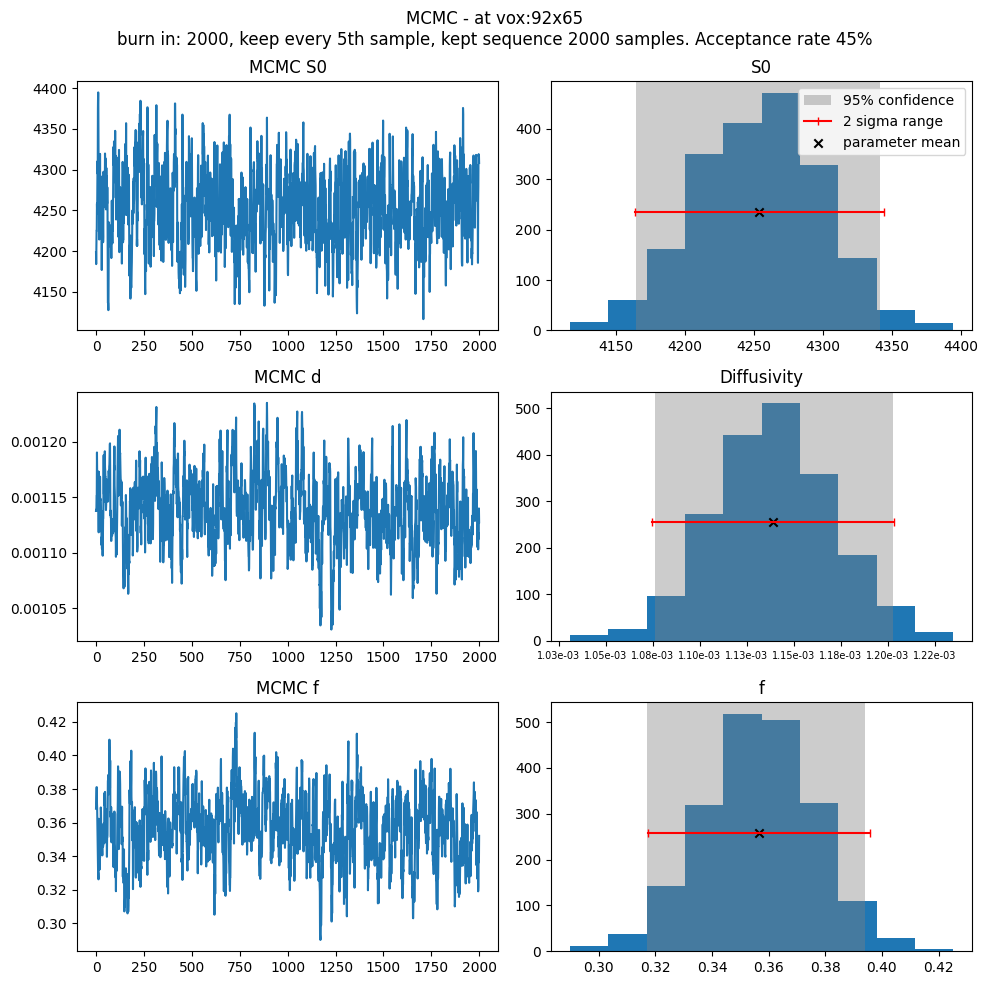

In [318]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle(f'MCMC - at vox:{vox_i+1}x{vox_j+1}\nburn in: {burn_in}, keep every {stride}th sample, kept sequence {sample_length} samples. Acceptance rate {100*acceptance_rate:.0f}%')

MCMC_S0 = MCMC_sequence[:,0]
MCMC_d = MCMC_sequence[:,1]
MCMC_f = MCMC_sequence[:,2]

burn_in_colour = 'grey'
shade_alpha = 0.4

axs[0,0].plot(MCMC_S0)
axs[0,0].set_title('MCMC S0')
axs[1,0].plot(MCMC_d)
axs[1,0].set_title('MCMC d')
axs[2,0].plot(MCMC_f)
axs[2,0].set_title('MCMC f')

MCMC_95_range, MCMC_2sigma_range = plot_histogram_sigma_95percent(axs[0, 1], MCMC_S0, 'S0', is_legend=True)
MCMC_95_range, MCMC_2sigma_range = plot_histogram_sigma_95percent(axs[1, 1], MCMC_d, 'Diffusivity')
MCMC_95_range, MCMC_2sigma_range = plot_histogram_sigma_95percent(axs[2, 1], MCMC_f, 'f')

axs[1,1].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
axs[1,1].tick_params(axis='x', labelsize=7)

print('MCMC parameter ranges\n')
print(f'Voxel: {vox_i+1}x{vox_j+1}')
print(f"S0: mean = {MCMC_S0.mean()}, 95% confidence = {MCMC_95_range}, 2sigma range = {MCMC_2sigma_range}")
print(f"Diffusivity: mean = {MCMC_d.mean()}, 95% confidence = {MCMC_95_range}, 2sigma range = {MCMC_2sigma_range}")
print(f"f: mean = {MCMC_f.mean()}, 95% confidence = {MCMC_95_range}, 2sigma range = {MCMC_2sigma_range}\n")

plt.tight_layout()